In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/crisis_1987.csv', index_col=0, parse_dates=True)
df

,Price
Date,
1986-10-03,233.71
1986-10-06,234.78
1986-10-07,234.41
1986-10-08,236.68
1986-10-09,235.85
...,...
1987-10-26,227.67
1987-10-27,233.19
1987-10-28,233.28


In [3]:
from econometrics import log_return
df['Return'] = log_return(df['Price'])
df

,Price,Return
Date,,
1986-10-03,233.71,NaN
1986-10-06,234.78,0.004568
1986-10-07,234.41,-0.001577
1986-10-08,236.68,0.009637
1986-10-09,235.85,-0.003513
...,...,...
1987-10-26,227.67,-0.086418
1987-10-27,233.19,0.023956
1987-10-28,233.28,0.000386


# 1. October 1987

## a. Historical Simulation VaR

In [4]:
# period for which to compute VaR
start_date = '1987-10-01'
end_date = '1987-10-30'

m = 250  # past observations to use
confidence = 0.99  # confidence interval

In [5]:
from econometrics import var_historical_simulation

var_long_hs = var_historical_simulation(df['Return'], start_date, end_date, m, confidence)
var_short_hs = var_historical_simulation(-df['Return'], start_date, end_date, m, confidence)

var_long_hs.name = 'VaR HS Long'
var_short_hs.name = 'VaR HS Short'

pd.concat([var_long_hs, var_short_hs], axis=1)

,VaR HS Long,VaR HS Short
1987-10-01,0.023725,0.023575
1987-10-02,0.023725,0.023575
1987-10-05,0.023725,0.023575
1987-10-06,0.023725,0.023575
1987-10-07,0.024310,0.023575
1987-10-08,0.024310,0.023575
1987-10-09,0.024310,0.023575
1987-10-12,0.024310,0.023575
1987-10-13,0.024310,0.023575
1987-10-14,0.024310,0.023575


## a. Weighted Historical Simulation VaR

Computing the weights

In [6]:
def nu_tau(nu, tau, m):
    return np.power(nu, tau - 1) * (1 - nu) / (1 - nu ** m)

In [7]:
nu = 0.99

weights_list = [nu_tau(nu, tau, m) for tau in range(1, m + 1)]
weights = pd.Series(weights_list[::-1])
weights.name = 'Weight'

weights

0      0.000891
1      0.000900
2      0.000909
3      0.000918
4      0.000928
         ...   
245    0.010453
246    0.010559
247    0.010666
248    0.010773
249    0.010882
Name: Weight, Length: 250, dtype: float64

In [8]:
from econometrics import var_weighted_historical_simulation

var_long_whs = var_weighted_historical_simulation(df['Return'], start_date, end_date, m, weights, confidence)
var_short_whs = var_weighted_historical_simulation(-df['Return'], start_date, end_date, m, weights, confidence)

var_long_whs.name = 'VaR WHS Long'
var_short_whs.name = 'VaR WHS Short'

pd.concat([var_long_whs, var_short_whs], axis=1)

,VaR WHS Long,VaR WHS Short
1987-10-01,0.023680,0.028445
1987-10-02,0.023680,0.028445
1987-10-05,0.023680,0.028445
1987-10-06,0.023680,0.024333
1987-10-07,0.027377,0.024333
1987-10-08,0.027377,0.024333
1987-10-09,0.027377,0.024333
1987-10-12,0.027377,0.024333
1987-10-13,0.027377,0.024333
1987-10-14,0.027377,0.024333


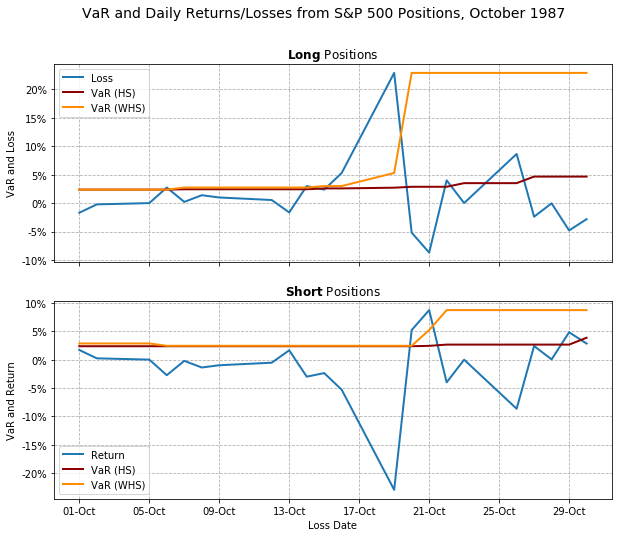

In [47]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
date_fmt = mdates.DateFormatter('%d-%b')

ret_october = df.loc[start_date : end_date, 'Return']

fig, (long, short) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

fig.suptitle('VaR and Daily Returns/Losses from S&P 500 Positions, October 1987', fontsize=14)
  
long.plot(-ret_october, label='Loss', lw='2')
long.plot(var_long_hs, label='VaR (HS)', c='darkred', lw='2')
long.plot(var_long_whs, label='VaR (WHS)', c='darkorange', lw='2')
long.legend(loc=2)
long.set(ylabel='VaR and Loss',
        title=r'$\bf{' + 'Long' + '}$' + ' Positions')

short.plot(ret_october, label='Return', lw='2')
short.plot(var_short_hs, label='VaR (HS)', c='darkred', lw='2')
short.plot(var_short_whs, label='VaR (WHS)', c='darkorange', lw='2')
short.legend(loc=3)
short.set(xlabel='Loss Date', ylabel='VaR and Return',
        title=r'$\bf{' + 'Short' + '}$' + ' Positions')
short.xaxis.set_major_formatter(date_fmt)

for ax in (long, short):
    ax.grid(ls='dashed')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))

plt.show()

# 2. 2008-2009 Crisis

In [10]:
sp500 = pd.read_csv('data/crisis_2008.csv', index_col=0, parse_dates=True)
sp500

,Price
Date,
1999-12-31,2021.40
2000-01-04,1925.41
2000-01-05,1929.28
2000-01-06,1931.51
2000-01-07,1983.83
...,...
2010-03-29,1942.51
2010-03-30,1942.81
2010-03-31,1936.48


In [11]:
sp500['Return'] = log_return(sp500['Price'])
sp500

,Price,Return
Date,,
1999-12-31,2021.40,NaN
2000-01-04,1925.41,-0.048651
2000-01-05,1929.28,0.002008
2000-01-06,1931.51,0.001155
2000-01-07,1983.83,0.026727
...,...,...
2010-03-29,1942.51,0.005850
2010-03-30,1942.81,0.000154
2010-03-31,1936.48,-0.003263


## a. VaR: Historical Simulation vs Risk Metrics

In [12]:
def risk_metrics(returns):
    variance = pd.Series(index=returns.index, dtype='float64', name='RM Variance')
    variance[0] = np.nan
    variance[1] = 0
    start_idx = 2  # starting index for computing volatility
    for i in range(start_idx, len(returns)):
        variance[i] = 0.94 * variance[i - 1] + 0.06 * returns[i - 1] ** 2
    return variance

sp500['RM Variance'] = risk_metrics(sp500['Return'])
sp500['RM Std'] = np.sqrt(sp500['RM Variance'])
sp500

,Price,Return,RM Variance,RM Std
Date,,,,
1999-12-31,2021.40,NaN,NaN,NaN
2000-01-04,1925.41,-0.048651,0.000000,0.000000
2000-01-05,1929.28,0.002008,0.000142,0.011917
2000-01-06,1931.51,0.001155,0.000134,0.011565
2000-01-07,1983.83,0.026727,0.000126,0.011216
...,...,...,...,...
2010-03-29,1942.51,0.005850,0.000055,0.007391
2010-03-30,1942.81,0.000154,0.000053,0.007308
2010-03-31,1936.48,-0.003263,0.000050,0.007085


In [13]:
from scipy.stats import norm

start_date2 = '2008-07-01'
end_date2 = '2009-12-30'
m2 = 250
confidence2 = 0.99

# 10 day VaR
var_sp500_hs = np.sqrt(10) * var_historical_simulation(sp500['Return'], start_date2, end_date2, m2, confidence2)
var_sp500_rm = -np.sqrt(10) * sp500.loc[start_date2 : end_date2, 'RM Std'] * norm().ppf(1-confidence2)

var_financial_crisis = pd.concat([var_sp500_hs, var_sp500_rm], axis=1)
var_financial_crisis.columns = ['VaR HS', 'VaR RM']
var_financial_crisis

,VaR HS,VaR RM
2008-07-01,0.096751,0.088036
2008-07-02,0.096751,0.085661
2008-07-03,0.096751,0.089370
2008-07-07,0.096751,0.086671
2008-07-08,0.096751,0.085384
...,...,...
2009-12-22,0.155146,0.067822
2009-12-24,0.148933,0.066071
2009-12-28,0.148933,0.065564
2009-12-29,0.148933,0.063609


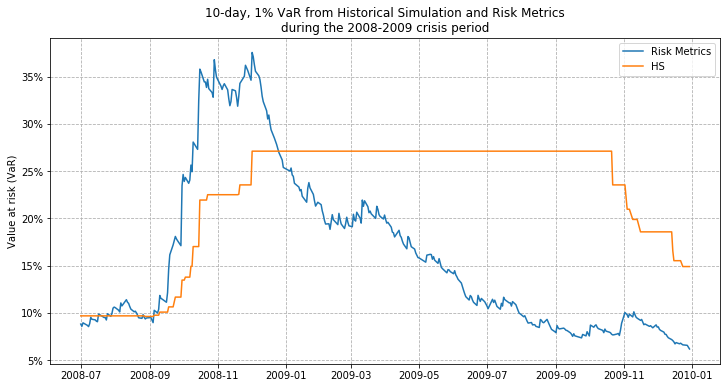

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(var_financial_crisis['VaR RM'], label='Risk Metrics')
ax.plot(var_financial_crisis['VaR HS'], label='HS')

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))

ax.set(ylabel='Value at risk (VaR)', 
       title='10-day, 1% VaR from Historical Simulation and Risk Metrics\nduring the 2008-2009 crisis period')
ax.grid(ls='dashed')
ax.legend()

## b. Profit/Loss

In [15]:
var_financial_crisis['Simple Return'] = sp500['Price'].pct_change().loc[start_date2 : end_date2]

limit = 100000  # VaR limit

pnl = pd.DataFrame()

pnl['Position HS'] = limit / var_financial_crisis['VaR HS']
pnl['Position RM'] = limit / var_financial_crisis['VaR RM']

pnl['PnL HS'] = pnl['Position HS'] * var_financial_crisis['Simple Return']
pnl['PnL RM'] = pnl['Position RM'] * var_financial_crisis['Simple Return']

var_financial_crisis['Cum PnL HS'] = pnl['PnL HS'].cumsum()
var_financial_crisis['Cum PnL RM'] = pnl['PnL RM'].cumsum()

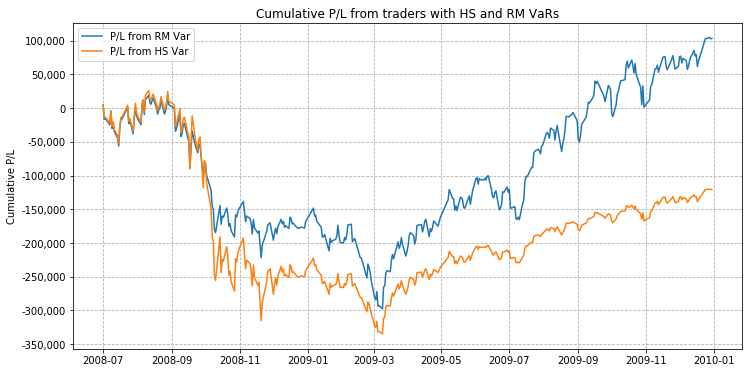

In [42]:
import matplotlib.ticker as ticker
fmt = ticker.FormatStrFormatter('%.0f')

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(var_financial_crisis['Cum PnL RM'], label='P/L from RM Var')
ax.plot(var_financial_crisis['Cum PnL HS'], label='P/L from HS Var')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))  # thousands separator
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))  # 50,000 spacing

ax.set(ylabel='Cumulative P/L', 
       title='Cumulative P/L from traders with HS and RM VaRs')
ax.grid(ls='dashed')
ax.legend()

plt.show()